# `scipy`
A large collection of functions related to scientific computing and data analysis. Makes heavy use of `numpy` and provides a Python interface to many F77 libraries. These slides give a non-exhaustive overview of the functionality.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt

## Special functions
A large number of special functions is available in `scipy.special`. All of them accept scalars and numpy arrays as arguments.

In [2]:
from scipy import special

### Some Examples
#### $\Gamma$ function

In [3]:
special.gamma(30)

8.8417619937397008e+30

Recall that for integer values: $n! = \Gamma(n+1)$.

In [4]:
special.factorial(29) - special.gamma(30)

0.0

Factorials are actually approximated using $\Gamma$. We can force exact integer evaluation to see the error introduced by floating-point arithmetic

In [5]:
special.factorial(29, exact=True) - special.gamma(30)

1125899906842624.0

This is of the order of $10^{-16}$ as expected.

### Special Polynomials
These return a polynomial object with the coefficients.
#### Legendre polynomials

In [6]:
p = special.legendre(3)
print(p)

     3
2.5 x - 1.5 x


It can be evaluated like a function.

In [7]:
p(0.5)

-0.43749999999999994

Derivatives can be computed directly from the coefficients.

In [8]:
print(p.deriv())

     2
7.5 x - 1.5


#### Chebychev polynomials
`chebyt` are the polynomials of first kind ($T_n$), `chebyu` of second kind ($U_n$).

In [9]:
print(special.chebyt(5))

    5             4      3             2
16 x - 1.776e-15 x - 20 x + 2.665e-15 x + 5 x - 3.062e-16


Let's check the recurrence relation.
$$T_{n+1} = 2x T_n - T_{n-1}$$

In [10]:
print(special.chebyt(4) * 2 * np.poly1d([1,0]) - special.chebyt(3))

    5      3            2
16 x - 20 x + 2.22e-15 x + 5 x - 1.837e-16


In [11]:
print(special.chebyt(5))

    5             4      3             2
16 x - 1.776e-15 x - 20 x + 2.665e-15 x + 5 x - 3.062e-16


## Spherical harmonics
The implementation in `sph_harm` does *not* use the Condon–Shortley phase ($(-1)^m$ for $m>0$) common in quantum mechanics.

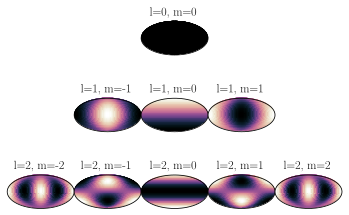

In [12]:
phi, theta = np.meshgrid(np.linspace(-np.pi,np.pi),np.linspace(0,np.pi))
gr = plt.GridSpec(3,5,wspace=0)
for l in range(3):
    for m in range(-l,l+1):
        ax = plt.subplot(gr[l,m+2], projection='mollweide')
        ax.set_title('l={}, m={}'.format(l,m))
        ax.pcolormesh(phi, 0.5 * np.pi - theta,
                      np.real(special.sph_harm(m,l,phi,theta)),
                     rasterized=True)
        ax.set_xticks([]); ax.set_yticks([])

## Constants
Many physical constants are available in the `constants` module. The data are taken from the CODATA 2014 recommendations. Values are given in SI units. More advanced handling of units attached to values is provided by the `astropy.units` package.

In [13]:
from scipy import constants

In [14]:
constants.gravitational_constant # also constants.G

6.67408e-11

In [15]:
constants.Avogadro # also constants.N_A

6.022140857e+23

Additional information is available in the dictionary `physical_constants`. Each value also has information on its unit and uncertainty.

In [16]:
constants.physical_constants['molar gas constant']

(8.3144598, 'J mol^-1 K^-1', 4.8e-06)

In [17]:
constants.physical_constants['Newtonian constant of gravitation']

(6.67408e-11, 'm^3 kg^-1 s^-2', 3.1e-15)

#### Unit conversion
A simple function to convert temperatures is provided. See `astropy.units` for a complete unit conversion package.

In [18]:
constants.convert_temperature(0.,'C', 'F')

32.0

In [19]:
constants.convert_temperature(1,'K','R')
# Kelvin to Rankine

1.8

## Interpolation
The `interpolate` module provides several polynomial and spline interpolators as well as interpolators for multidimensional data. It also provides an interface to several FITPACK routines.

In [20]:
from scipy import interpolate

In [21]:
# generate some data
x = np.linspace(0, 2 * np.pi, 101) # fine grid for plotting
f = lambda x: np.sin(x) + 0.5 * np.cos(3.5 * x)
y = f(x)
xd = x[::10]; yd = y[::10] # coarse data for fitting

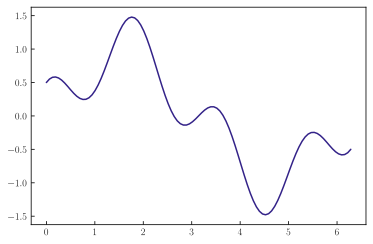

In [22]:
plt.plot(x,y)

### Simple 1D interpolation

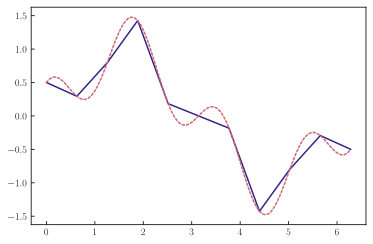

In [23]:
linear = interpolate.interp1d(xd,yd)
# linear is a callable function
plt.plot(x, linear(x))
plt.plot(x, y, ls=':')

Apart from the default, `'linear'`, other interpolation methods can be selected. Starting with `'quadratic'`, splines are used to ensure smooth derivatives.

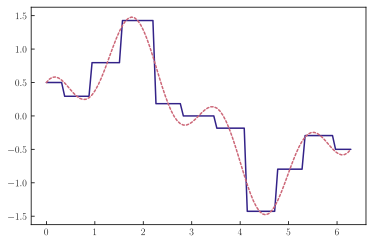

In [24]:
nearest = interpolate.interp1d(xd,yd,kind='nearest')
plt.plot(x, nearest(x))
plt.plot(x, y, ls=':')

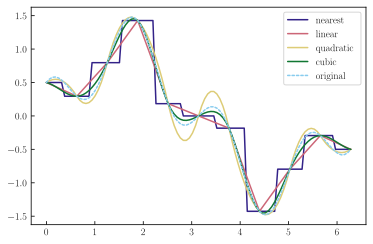

In [25]:
for k in ['nearest', 'linear', 'quadratic', 'cubic']:
    interp = interpolate.interp1d(xd, yd, kind=k)
    plt.plot(x, interp(x), label=k)
plt.plot(x, y, ls=':', label='original')
plt.legend()

### Generic Interface
`interpolate.UnivariateSpline` provides a generic object-oriented interface to splines. It supports up to fifth order and can apply smoothing to data. Data points can be given individual weights (e.g., error estimates).

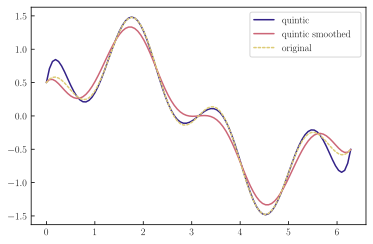

In [26]:
quint = interpolate.UnivariateSpline(xd, yd, k=5, s=0)
quints = interpolate.UnivariateSpline(xd, yd, k=5, s=0.1)
plt.plot(x, quint(x), label='quintic')
plt.plot(x, quints(x), label='quintic smoothed')
plt.plot(x, y, ls=':', label='original')
plt.legend()

### Monotonicty
PCHIP provides a cubic splines which preserves monotonicity in data and does not overshoot on discontinuous data.

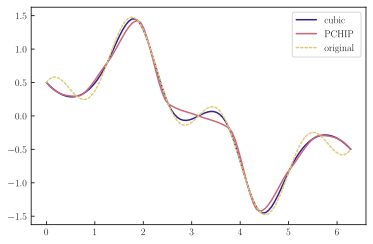

In [27]:
cubic = interpolate.CubicSpline(xd, yd)
pchip = interpolate.PchipInterpolator(xd, yd)
plt.plot(x, cubic(x), label='cubic')
plt.plot(x, pchip(x), label='PCHIP')
plt.plot(x, y, ls=':', label='original')
plt.legend()

#### Discontinuous data
In the last example PCHIP performed worse than the cubic spline because the sampled data were monotonous even though the original function was not. Its strength shows when applied to discontinous functions.

In [28]:
g = lambda x: np.where(x<np.pi, np.sin(x), np.cos(x))

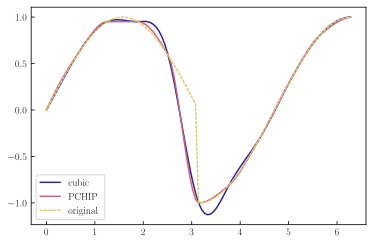

In [29]:
cubic = interpolate.CubicSpline(xd, g(xd))
pchip = interpolate.PchipInterpolator(xd, g(xd))
plt.plot(x, cubic(x), label='cubic')
plt.plot(x, pchip(x), label='PCHIP')
plt.plot(x, g(x), ls=':', label='original')
plt.legend()

### Derivatives
Splines naturally provide derivates. The argument to `derivate` specifies the order of the derivate. -1 computes the antiderivative.

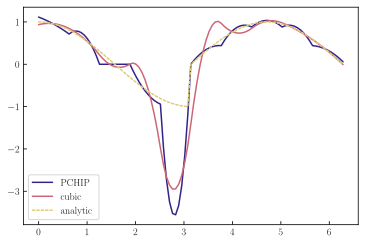

In [30]:
cubicd = cubic.derivative(); pchipd = pchip.derivative()
# Analytic derivative
gd = lambda x: np.where(x<np.pi, np.cos(x), -np.sin(x))
plt.plot(x, pchipd(x), label='PCHIP')
plt.plot(x, cubicd(x), label='cubic')
plt.plot(x, gd(x), ls=':', label='analytic')
plt.legend()

#### Smooth example

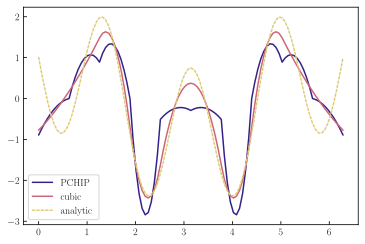

In [31]:
cubicd = interpolate.CubicSpline(xd, f(xd)).derivative()
pchipd = interpolate.PchipInterpolator(xd, f(xd)).derivative()
fd = lambda x: np.cos(x) - 0.5 * 3.5 * np.sin(3.5 * x)
plt.plot(x, pchipd(x), label='PCHIP')
plt.plot(x, cubicd(x), label='cubic')
plt.plot(x, fd(x), ls=':', label='analytic')
plt.legend()

### Extrapolation
By default the interpolators raise an exception when applied outside the range of input data. We can set a fixed value for this range or allow extrapolation.

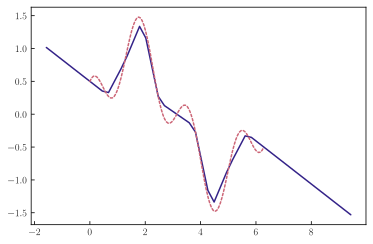

In [32]:
interp = interpolate.interp1d(xd, yd, kind='linear',
                              fill_value='extrapolate')
extrax = np.linspace(-0.5 * np.pi, 3 * np.pi)
plt.plot(extrax, interp(extrax))
plt.plot(x, y, ls=':', label='original')

### Polynomial interpolation
$n$ data points can be interpolated with a single polynomial function of degree $n-1$.

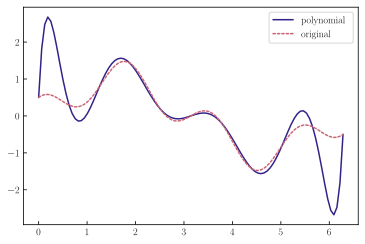

In [33]:
poly = interpolate.BarycentricInterpolator(xd,yd)
plt.plot(x,poly(x), label='polynomial')
plt.plot(x, y, ls=':', label='original')
plt.legend()

Equidistant data points combinded with high order polynomials generally produce strong oscillations at the boundary of the domain. This is known as Runge's phenomenon. This can be reduced by using splines (above) or choosing another set of nodes.

In [34]:
# Chebyshev nodes
a, b = 0, 2 * np.pi
xc = 0.5*(np.cos(np.pi*(2*np.arange(1,11) - 1)/(2*10))*(b-a) + a + b)
yc = f(xc)

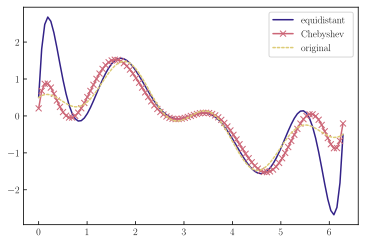

In [35]:
polycheb = interpolate.BarycentricInterpolator(xc,yc)
plt.plot(x,poly(x), label='equidistant')
plt.plot(x,polycheb(x), marker='x', label='Chebyshev')
plt.plot(x, y, ls=':', label='original')
plt.legend()

### Multidimensional data
The interpolate module offers bivariate splines with variable degree in both dimensions. This only supports Cartesian geometry.

In [36]:
# generate data
h = lambda x, y: np.exp(-x**2-y**2)
# fine grid
X, Y = np.meshgrid(np.linspace(-1,1,101),np.linspace(-1,1,101))
# coarse grid
Xc, Yc = np.meshgrid(np.linspace(-1,1,10),np.linspace(-1,1,10))
Z = h(X, Y)
Zc = h(Xc, Yc)

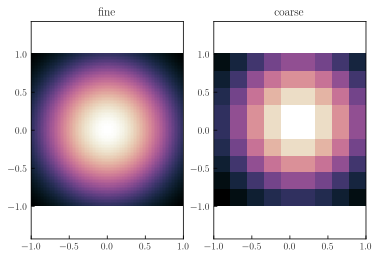

In [37]:
plt.subplot(121); plt.axis('equal'); plt.title('fine')
plt.pcolormesh(X, Y, Z, rasterized=True)
plt.subplot(122); plt.axis('equal'); plt.title('coarse')
plt.pcolormesh(Xc, Yc, Zc, rasterized=True)

In [38]:
bspl = interpolate.SmoothBivariateSpline(Xc.flat, Yc.flat, Zc.flat)

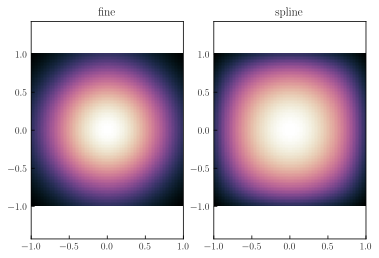

In [39]:
plt.subplot(121); plt.axis('equal'); plt.title('fine')
plt.pcolormesh(X, Y, Z, rasterized=True)
plt.subplot(122); plt.axis('equal'); plt.title('spline')
plt.pcolormesh(X, Y, bspl(X[0,:], Y[:,0]), rasterized=True)

#### Unstructrured data
`LinearNDInterpolator` takes data sampled at arbitrary points and interpolates on a triangulated grid.

In [40]:
# random sampling points
Xp = np.random.uniform(-1, 1,50)
Yp = np.random.uniform(-1, 1,50)

In [41]:
ndinterp = interpolate.LinearNDInterpolator(np.array([Xp, Yp]).T, h(Xp, Yp), fill_value=0.)

(-1.1064158186856234, 1.0, -1.0, 1.1279869776492313)

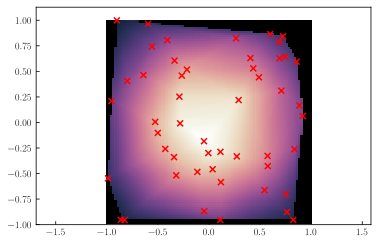

In [42]:
plt.pcolormesh(X, Y, ndinterp(X, Y), rasterized=True)
plt.scatter(Xp, Yp, marker='x', color='red'); plt.axis('equal')

## Root finding
The `optimize` module provides routines for root finding and fitting.

In [43]:
from scipy import optimize

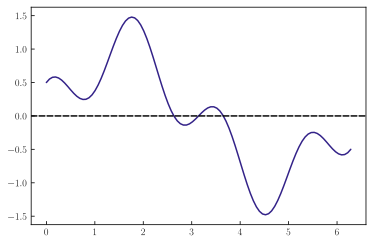

In [44]:
# example function from before
plt.plot(x,f(x))
plt.axhline(0., ls='--', color='k')

In [45]:
optimize.root(f, 2.) # second argument is the starting value

    fjac: array([[-1.]])
     fun: array([  1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([  4.28423963e-12])
       r: array([ 1.24648718])
  status: 1
 success: True
       x: array([ 2.63127494])

The result is a `OptimizeResult` object, which contains further information on the solution. The actual solution is stored in the `x` attribute.

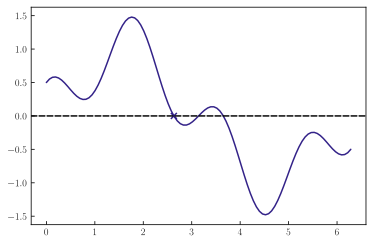

In [46]:
sol = optimize.root(f, 2.)
plt.plot(x,f(x))
plt.axhline(0., ls='--', color='k')
plt.scatter(sol.x, f(sol.x), marker='x')

Other solutions are found by choosing a different starting value.

In [47]:
optimize.root(f,3.)

    fjac: array([[-1.]])
     fun: array([ -9.18485099e-17])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([  2.69516945e-10])
       r: array([-0.75])
  status: 1
 success: True
       x: array([ 3.14159265])

In [48]:
optimize.root(f,4.)

    fjac: array([[-1.]])
     fun: array([  2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([  9.88454318e-11])
       r: array([ 1.24648815])
  status: 1
 success: True
       x: array([ 3.65191036])

Local minima can be a problem.

In [49]:
optimize.root(f,1.)

    fjac: array([[-1.]])
     fun: array([ 0.24502514])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 22
     qtf: array([-0.24502514])
       r: array([ 0.00042162])
  status: 5
 success: False
       x: array([ 0.77783047])

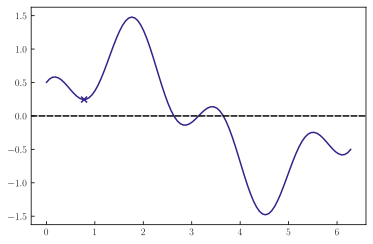

In [50]:
sol = optimize.root(f, 1.)
plt.plot(x,f(x))
plt.axhline(0., ls='--', color='k')
plt.scatter(sol.x, f(sol.x), marker='x')

We can use other algorithms to avoid getting stuck in local minima. Some of these make use of backtracking.

In [51]:
optimize.root(f, 1.0, method='broyden1')

     fun: array([ -1.01421047e-08])
 message: 'A solution was found at the specified tolerance.'
     nit: 10
  status: 1
 success: True
       x: array(-0.28089229867841753)

### More advanced options
Some functions might take additional (fixed) parameters apart from `x`. We can pass them as a tuple.

In [52]:
f2 = lambda x, ph, off: np.sin(x + ph) + off
optimize.root(f2, 0, args=(0.3, 0.0))

    fjac: array([[-1.]])
     fun: array([ 0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([  1.96194849e-09])
       r: array([-1.])
  status: 1
 success: True
       x: array([-0.3])

#### Callbacks
A callback function can be used to monitor convergence progress.

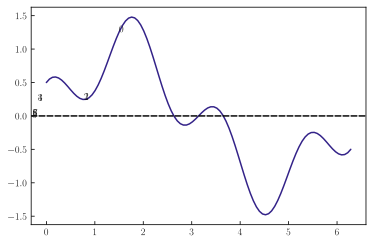

In [53]:
i = 0
def progress(x, y):
    global i
    plt.annotate(str(i), (x, y))
    i += 1
sol = optimize.root(f, 1.0, method='broyden1', callback=progress)
plt.plot(x,f(x)); plt.axhline(0., ls='--', color='k')

#### Explicit Jacobian
Newton methods rely on the derivative. The default is to compute it using finite differences. Alternatively we can provide it using an explicit expression. This can be advantageous in terms of stability and efficiency, especially for functions that are expensive to evaluate.

In [54]:
optimize.root(f,2.0, jac=fd) # fd was defined in the spline example

    fjac: array([[-1.]])
     fun: array([  1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
    njev: 1
     qtf: array([  4.28423963e-12])
       r: array([ 1.24648718])
  status: 1
 success: True
       x: array([ 2.63127494])

### Multivariate functions
`f` and `x` can be vector valued. They must have the same dimension for root finding. Use minimize function under- and over-determined systems.

In [55]:
f3 = lambda v: [np.cos(v[0] * v[1]), v[0]**2 - v[1]]

In [56]:
optimize.root(f3,[1,0])

    fjac: array([[-0.50539205,  0.86288984],
       [-0.86288984, -0.50539205]])
     fun: array([  2.91490756e-14,  -1.79856130e-14])
 message: 'The solution converged.'
    nfev: 25
     qtf: array([ -2.74510088e-09,  -1.49387666e-09])
       r: array([-2.70562263, -0.29402677,  1.49836439])
  status: 1
 success: True
       x: array([-1.16244735,  1.35128385])

For systems with a very high number of dimensions, `method='krylov'` can be used to get an approximation for the inverse Jacobian. This should be much more efficient than a direct solution.

## Fitting
### Linear fits
This not only applies to linear functions but anything that can be transformed into a function that linearly depends on the parameters.

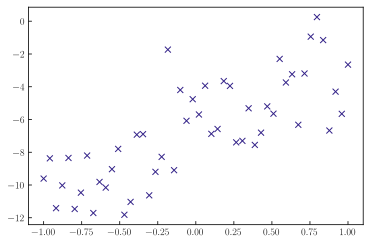

In [57]:
# First some data with random noise
x = np.linspace(-1,1)
y = 5. * x - 7. + np.random.normal(scale=2.0,size=len(x))
plt.plot(x,y,'x')

`numpy.polyfit` fits the data with a polynomial of the given degree in the least-squares sense.

[ 3.98287532 -6.65829321]


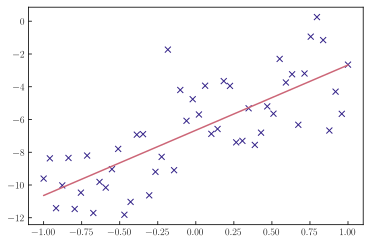

In [58]:
coeffs = np.polyfit(x,y,1)
print(coeffs)
plt.plot(x,y,'x')
plt.plot(x,np.poly1d(coeffs)(x))

### Non-linear fits
A generic interface to non-linear least-squares fits is provided by `optimize.curve_fit`. It can also handle constraints on the parameters.

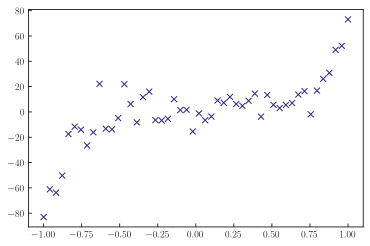

In [59]:
# more complicated data
x = np.linspace(-1,1)
y = np.sinh(5. * x) + np.random.normal(scale=10.0,size=len(x))
plt.plot(x,y,'x')

In [60]:
def fitfun(x, a, b):
    return a * np.exp(b * x)
opt, cov = optimize.curve_fit(fitfun, x, y)
print(opt)
print(cov)

[ 0.13271777  6.28809314]
[[ 0.09269867 -0.7373839 ]
 [-0.7373839   5.90677937]]


Optimal parameters and covariance matrix are returned. This is an iterative process and the result depends on the starting value (by default all parameters are set to 1).

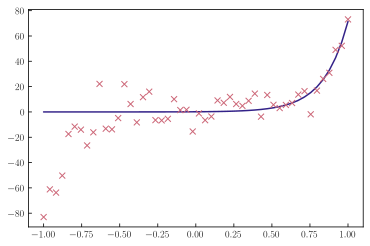

In [61]:
plt.plot(x, fitfun(x, *opt))
plt.plot(x,y,'x')

For the proper fit we need two exponentials.

$$\sinh x = \frac{e^x - e^{-x}}{2}$$

In [62]:
def fitfun2(x, a, b, c, d):
    return a * np.exp(b * x) + c * np.exp(d * x)
opt, cov = optimize.curve_fit(fitfun2, x, y, p0=[1,1,-1,-1])
print(opt)
print(cov)

[ 0.13407153  6.27733772 -0.08284892 -6.96303914]
[[  2.02895750e-02  -1.59998745e-01  -4.53770902e-05   5.71764834e-04]
 [ -1.59998745e-01   1.27059465e+00   3.57128459e-04  -4.49974610e-03]
 [ -4.53770902e-05   3.57128459e-04   6.98503705e-03  -8.85592474e-02]
 [  5.71764834e-04  -4.49974610e-03  -8.85592474e-02   1.12908043e+00]]


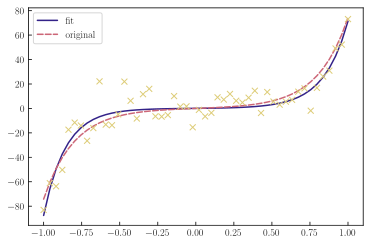

In [63]:
plt.plot(x, fitfun2(x, *opt), label='fit')
plt.plot(x, fitfun2(x, 0.5,5,-0.5,-5), ls='--', label='original')
plt.plot(x,y,'x')
plt.legend()

## Integration
`scipy.integrate` contains routines for computing one or multidimensional integrals of functions or sampled data. It also provides an interface to many ODE integrators.

In [64]:
from scipy import integrate

### General-purpose function integrator
`quad` is an interface to the Fortran library QUADPACK. It is convenient when the integrand is available as a callable function.

In [65]:
def f(x):
    return np.sin(x) + np.sqrt(x)
def F(x): # analytic solution for verification
    return - np.cos(x) + 2./3. * x**(1.5)

In [66]:
integrate.quad(f,0.,2.)

(3.3017649197112693, 3.665695435763082e-15)

The return value is the result and an error estimate. You can set `full_output=True` to get more diagnostic output.

In [67]:
F(2) - F(0)

3.3017649197112693

One or both of the integration limits can be infinite.`

In [68]:
def g(x):
    return np.exp(-x**2)

In [69]:
integrate.quad(g,-np.inf,np.inf)

(1.7724538509055159, 1.4202636780944923e-08)

In [70]:
np.sqrt(np.pi)

1.7724538509055159

### Sampled data
If just a fixed set of data samples is available, we can use `simps` to apply Simpson's rule to integrate the data.

In [71]:
# create data sample
x = np.linspace(0.,2.,10)
y = f(x)

In [72]:
integrate.simps(y,x=x)

3.2882074187938404

In [73]:
F(2)-F(0)

3.3017649197112693

## Cumulative integration
Assume there is sampled data of a function $f(x)$ and you need to compute
$$\int_0^x f(t)dt.$$
It is not efficient to compute the full integral for every point. Cumulative integration reuses the previous result.

In [74]:
y_int = integrate.cumtrapz(y, x=x, initial=0)
# cumulative trapezoidal rule on sampled data

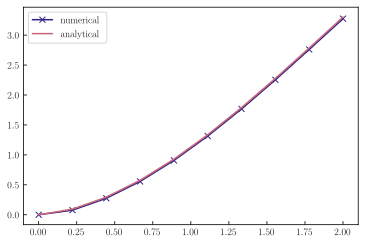

In [75]:
plt.plot(x,y_int, marker='x', label='numerical')
plt.plot(x, F(x) - F(0), label='analytical')
plt.legend()

### Ordinary differential equations
`integrate.ode` provides an interface to a variety of ODE integration methods. It allows us to set up the problem once and try many different integrators.

Simple example:
$$y''(x) = - y(x)$$

We need to reformulate the ODE as a first-order system.

$$Y = (Y_0, Y_1)^T = (y',y)^T\\
Y' = (-Y_1, Y_0)$$

In [76]:
def h(x,Y):
    return [-Y[1], Y[0]]

In [77]:
ode=integrate.ode(h)

In [78]:
ode.set_initial_value([0,1], t=0.)
ode.y

array([ 0.,  1.])

In [79]:
# sample the solution over an interval
x = np.linspace(0.01,4*np.pi)
y = [ode.integrate(t)[1] for t in x]
# Here we extract just the y component

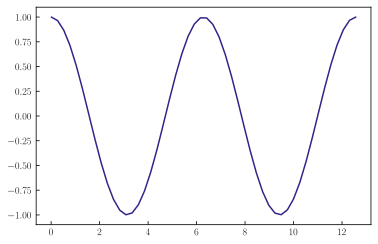

In [80]:
plt.plot(x,y)

#### Switching integrators
The default is the VODE, which uses implicit time stepping. Among others there is an explicit Runge–Kutta method.

In [81]:
ode=integrate.ode(h)

In [82]:
ode.set_initial_value([0,1], t=0.)
ode.set_integrator('dopri5') 
ode.y

array([ 0.,  1.])

In [83]:
x = np.linspace(0.01,4*np.pi)
y = [ode.integrate(t)[1] for t in x]

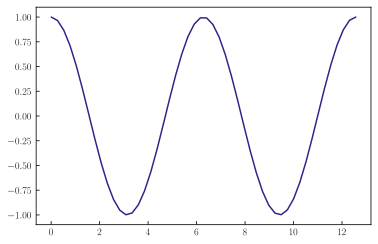

In [84]:
plt.plot(x,y)

## I/O
Many programming languages make use of special binary formats. `scipy.io` has methods for reading a few of these, for example Fortran unformatted output, Matlab `.mat` files, or IDL save files.

In [85]:
from scipy import io

### Fortran unformatted output
Consider the following Fortran code
```fortran
program testout
   implicit none
   integer, parameter :: n=200
   real :: a(n)
   integer :: i
   do i=1,n
      a(i) = i
   end do
   open(42,file='fortranout',form='unformatted')
   write(42) n
   write(42) a
   close(42)
end program
```

In [86]:
f=io.FortranFile('fortranout')
f.read_ints(dtype='i4')

array([200], dtype=int32)

In [87]:
f.read_reals(dtype='f4')

array([   1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,
         10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,
         19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,
         28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   54.,
         55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,
         64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,

- Records involving more than one type can be read using the `read_record` method.
- You can specify endianness in the dtype like `'>f8'` (big endian double precision float) `'<i4'` (little endian 4-byte integer)
- Fortran arrays are column-major, numpy arrays are row-major by default. Loaded data is one-dimensional at first. Reshape it using Fortran ordering with
  ```python
  A = f.read_reals()
  A.reshape((n,m),order='F')
  ```
- FortranFile can also be used to write files by specifying `mode='w'` when opening.

### Matlab
Matlab uses `.mat` files to save variables in binary form. Scipy has routines to load and save `.mat` files.

Consider the following Matlab code:
```matlab
A=rand(300,300);
save test.mat A
```

In [88]:
io.loadmat('test.mat')

{'A': array([[ 0.8937406 ,  0.33096039,  0.27772644, ...,  0.43196036,
          0.11713621,  0.38315384],
        [ 0.81624274,  0.85436018,  0.82194892, ...,  0.47457527,
          0.04818797,  0.54486213],
        [ 0.94742332,  0.36182472,  0.62477771, ...,  0.76898039,
          0.07675434,  0.69719725],
        ..., 
        [ 0.51246352,  0.82407083,  0.22070771, ...,  0.95076692,
          0.71071825,  0.01321776],
        [ 0.579559  ,  0.71837939,  0.71279853, ...,  0.2803856 ,
          0.56203512,  0.23141348],
        [ 0.84749724,  0.37592622,  0.51177889, ...,  0.84780634,
          0.1806365 ,  0.93363184]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Jun 15 11:10:58 2017',
 '__version__': '1.0'}

Data are returned in a dictionary. `io.savemat` can be used to write Matlab data files.

### IDL
Consider a file saved with the follwing IDL code
```idl
A = [1,2,3]
save, /variables, 'A', filename='idltest.sav'
```

In [89]:
io.readsav('idltest.sav')

{'a': array([1, 2, 3], dtype=int16)}

Writing these files is not supported at the moment.

## Sparse matrices
Scipy supports many operations on sparse matrices (matrices storing only the "few" non-zero entries). They occur in many problems, for example in discretisations of large systems of PDEs. It can convert between different sparse matrix formats and can make use of efficient algorithms on these matrices.

In [90]:
from scipy import sparse

In [91]:
# example matrix
A = np.diag(np.arange(1,31, dtype='f8'))
A[12,15] = 47.
A[20,0] = -15.

### Formats
Can be initialised using a normal (dense) matrix, a sparse matrix in another format, coordinate format `(data, (row_ind, col_ind))` or specifying the index vectors directly. The latter is really useful when reading sparse matrices from disk.

In [92]:
Asp = sparse.csc_matrix(A) # Compressed Sparse Column format
Asp.nnz # number of non-zero elements

32

In [93]:
Asp.indices

array([ 0, 20,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 12,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

In [94]:
Asp.indptr

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], dtype=int32)

In [95]:
Asp.data

array([  1., -15.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  47.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.])

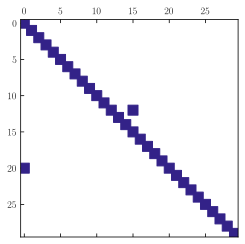

In [96]:
plt.spy(Asp)

In [97]:
Asp2 = Asp.tocoo() # to coordinate format

In [98]:
list(zip(Asp2.col, Asp2.row, Asp2.data))

[(0, 0, 1.0),
 (0, 20, -15.0),
 (1, 1, 2.0),
 (2, 2, 3.0),
 (3, 3, 4.0),
 (4, 4, 5.0),
 (5, 5, 6.0),
 (6, 6, 7.0),
 (7, 7, 8.0),
 (8, 8, 9.0),
 (9, 9, 10.0),
 (10, 10, 11.0),
 (11, 11, 12.0),
 (12, 12, 13.0),
 (13, 13, 14.0),
 (14, 14, 15.0),
 (15, 12, 47.0),
 (15, 15, 16.0),
 (16, 16, 17.0),
 (17, 17, 18.0),
 (18, 18, 19.0),
 (19, 19, 20.0),
 (20, 20, 21.0),
 (21, 21, 22.0),
 (22, 22, 23.0),
 (23, 23, 24.0),
 (24, 24, 25.0),
 (25, 25, 26.0),
 (26, 26, 27.0),
 (27, 27, 28.0),
 (28, 28, 29.0),
 (29, 29, 30.0)]

Sparse matrices behave like normal numpy arrays in many ways but use less storage. Linear algebra operations are carried out using more efficient algorithms if possible.

In [99]:
row2 = Asp[2,:]
row2 # slicing returns sparse matrices

<1x30 sparse matrix of type '<type 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Column format>

In [100]:
row2.todense() # conversion to dense storage

matrix([[ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]])

In [101]:
sparse.linalg.eigs(Asp)
# compute a few eigenvalues and vectors

(array([ 30.+0.j,  29.+0.j,  28.+0.j,  27.+0.j,  26.+0.j,  25.+0.j]),
 array([[  1.30222231e-17+0.j,   8.03647401e-17+0.j,  -2.49997416e-16+0.j,
           1.01434142e-16+0.j,   1.02948775e-16+0.j,  -2.25966860e-17+0.j],
        [ -5.31341930e-20+0.j,  -4.93439094e-20+0.j,   2.03387044e-18+0.j,
           7.89204051e-17+0.j,   9.44686339e-17+0.j,   5.19991793e-17+0.j],
        [  3.70984158e-17+0.j,   1.32225551e-16+0.j,   5.08493888e-17+0.j,
          -2.72611458e-17+0.j,  -6.41637097e-18+0.j,   3.44081045e-17+0.j],
        [  5.04157183e-17+0.j,   1.43629741e-16+0.j,   6.89875367e-17+0.j,
          -9.36689321e-17+0.j,   2.50725094e-16+0.j,  -3.09149839e-18+0.j],
        [ -4.23278638e-18+0.j,  -2.39944733e-17+0.j,  -2.92411617e-17+0.j,
           3.29802461e-17+0.j,   2.17836195e-17+0.j,  -2.84595274e-17+0.j],
        [  1.67532686e-17+0.j,   5.56445341e-17+0.j,   1.00706428e-16+0.j,
           8.48062406e-17+0.j,  -1.13756527e-16+0.j,   7.50869709e-17+0.j],
        [ -3.31475711e-1

### Iterative solvers
For very large sparse matrices it is not efficient and sometimes not even possible (due to memory) to compute the inverse of a matrix. There are very efficient iterative solution methods to linear systems. Some work on general matrices (GMRES, BiCGSTAB, ...), some only on symmetric matrices (CG, ...). Scipy implements some of these methods. 

In [102]:
b = np.ones(Asp.shape[0]) # RHS

In [103]:
# GMRES method for non-symmetric matrices
sparse.linalg.gmres(Asp, b)

(array([ 0.99999368,  0.50000344,  0.33332747,  0.25000626,  0.19999668,
         0.16666672,  0.14285699,  0.12500163,  0.11111062,  0.09999859,
         0.0909096 ,  0.08333444, -0.14904021,  0.07142836,  0.06666668,
         0.06250001,  0.0588236 ,  0.05555573,  0.05263146,  0.04999979,
         0.76190009,  0.04545487,  0.04347809,  0.04166662,  0.0399999 ,
         0.03846183,  0.03703678,  0.03571439,  0.03448273,  0.03333334]), 0)

In [104]:
sparse.linalg.bicgstab(Asp, b)

(array([ 0.99997922,  0.50001088,  0.33333347,  0.25000016,  0.20000001,
         0.16666667,  0.14285715,  0.12499997,  0.11111107,  0.1       ,
         0.09090909,  0.08333334, -0.14903857,  0.07142858,  0.0666667 ,
         0.06249999,  0.0588235 ,  0.05555555,  0.05263157,  0.04999999,
         0.76188918,  0.04545455,  0.04347822,  0.04166679,  0.04000058,
         0.03846133,  0.03703679,  0.03571399,  0.03448278,  0.03333268]), 0)

In [105]:
np.linalg.solve(A, b)

array([ 1.        ,  0.5       ,  0.33333333,  0.25      ,  0.2       ,
        0.16666667,  0.14285714,  0.125     ,  0.11111111,  0.1       ,
        0.09090909,  0.08333333, -0.14903846,  0.07142857,  0.06666667,
        0.0625    ,  0.05882353,  0.05555556,  0.05263158,  0.05      ,
        0.76190476,  0.04545455,  0.04347826,  0.04166667,  0.04      ,
        0.03846154,  0.03703704,  0.03571429,  0.03448276,  0.03333333])